# Generating a mock CGM spectrum in Simba

#### In this example notebook we'll select a galaxy in the 100 Mpc/h Simba simulation and produce a line of sight synthetic spectrum of its CGM.

1. Select a galaxy in Simba and print out its properties
2. Define a line of sight
3. Save a new dataset with only the relevant particles
4. Generate the line of sight spectra
5. Apply effects and wrap the spectrum
6. Show the spectra and physical line of sight features 
7. Fit the absorption features
8. Compute the equivalent width

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import numpy as np
import pygad as pg
import caesar
import yt
np.random.seed(1)

We'll set some parameters for reading in the simulation data. We need to choose the simulation volume ('model'), the Simba feedback physics mode ('wind') and the output snapshot number ('snap', a proxy for redshift). Available options:

Model:
- 'm100n1024', the 100 Mpc/h volume with $1024^3$ gas elements and dark matter particles
- 'm50n512', the 50 Mpc/h volume with $512^3$ gas elements and dark matter particles
- 'm25n256', the 25 Mpc/h volume with $256^3$ gas elements and dark matter particles
- 'm25n512', the 25 Mpc/h volume with $512^3$ gas elements and dark matter particles

Wind:
- 's50', the full Simba physics
- 's50nox', turning off X-ray feedback
- 's50nojet', turning off X-ray and jet feedback
- 's50noagn', turning off X-ray, jet and radiative feedback
- 's50nofb', turning off X-ray, jet and radiative black hole feedback and stellar winds

Snap:
- See http://simba.roe.ac.uk/outputs.txt for a reference list.

In [1]:
# Setting the simulation parameters:
model = 'm50n512'
wind = 's50'
snap = '151'

data_dir = '/disk04/sapple/cgm/absorption/ml_project/data/'
sim_dir = f'/home/rad/data/{model}/{wind}/'

In [6]:
def quench_thresh(z): # in units of yr^-1 
    return -1.8  + 0.3*z - 9.

# load in the galaxy and halo catalog with caesar:

sim = caesar.load(f'{sim_dir}Groups/{model}_{snap}.hdf5')
redshift = sim.simulation.redshift
quench = quench_thresh(redshift)

gal_sm = yt.YTArray([i.masses['stellar'].in_units('Msun') for i in sim.galaxies], 'Msun')
gal_sfr = yt.YTArray([i.sfr.in_units('Msun/yr') for i in sim.galaxies], 'Msun/yr')
gal_central = np.array([i.central for i in sim.galaxies])
gal_ssfr = gal_sfr / gal_sm


yt : [INFO     ] 2021-10-14 23:22:49,890 Opening /home/rad/data/m100n1024/s50/Groups/m100n1024_151.hdf5
yt : [INFO     ] 2021-10-14 23:22:49,960 Found 464043 halos
yt : [INFO     ] 2021-10-14 23:22:49,997 Found 55609 galaxies


We'll choose a galaxy in the Simba simulation to use as an example. Star forming galaxies are better as examples as they typically have larger absorption features, so let's choose a random central star forming galaxy. Also, we'll impose a resolution limit of galaxies with $ M_{\star} > 10^{10}{\rm M_{\odot}} $.

In [15]:
# get ids of star forming galaxies:
sf_ids = np.arange(len(sim.galaxies))[(gal_ssfr > quench) & (gal_sm > 1e10) & gal_central]
gal = sim.galaxies[np.random.choice(sf_ids, 1)[0]]

In [15]:
with h5py.File(sample_file, 'r') as sample:
    gal_sm = sample['mass'][:]
    gal_sfr = sample['sfr'][:]
    gal_fgas = sample['gas_frac'][:]
    gal_vpos = sample['vgal_position'][:]
    gal_ids = sample['gal_ids'][:]
    print(sample.keys())
gal_fgas[gal_fgas == 0] = 1e-3

<KeysViewHDF5 ['gal_ids', 'gas_frac', 'halo_pos', 'halo_r200', 'mass', 'position', 'sfr', 'ssfr', 'vgal_position']>


In [22]:
gal = gal_ids[3]
vgal = gal_vpos[3][2]
spectrum_file = f'{spectrum_dir}sample_galaxy_{gal}_0.25_r200_0_deg.h5'

sf = h5py.File(spectrum_file, 'r')
sf.keys()

<KeysViewHDF5 ['CIV1548_col_densities', 'CIV1548_flux', 'CIV1548_flux_conv', 'CIV1548_flux_conv_noise', 'CIV1548_flux_conv_noise_contin', 'CIV1548_flux_nonperiodic', 'CIV1548_noise', 'CIV1548_tau', 'CIV1548_tau_nonperiodic', 'CIV1548_temp', 'CIV1548_wavelength', 'H1215_col_densities', 'H1215_flux', 'H1215_flux_conv', 'H1215_flux_conv_noise', 'H1215_flux_conv_noise_contin', 'H1215_flux_nonperiodic', 'H1215_noise', 'H1215_tau', 'H1215_tau_nonperiodic', 'H1215_temp', 'H1215_wavelength', 'MgII2796_col_densities', 'MgII2796_flux', 'MgII2796_flux_conv', 'MgII2796_flux_conv_noise', 'MgII2796_flux_conv_noise_contin', 'MgII2796_flux_nonperiodic', 'MgII2796_noise', 'MgII2796_tau', 'MgII2796_tau_nonperiodic', 'MgII2796_temp', 'MgII2796_wavelength', 'NeVIII770_col_densities', 'NeVIII770_flux', 'NeVIII770_flux_conv', 'NeVIII770_flux_conv_noise', 'NeVIII770_flux_conv_noise_contin', 'NeVIII770_flux_nonperiodic', 'NeVIII770_noise', 'NeVIII770_tau', 'NeVIII770_tau_nonperiodic', 'NeVIII770_temp', 'NeVII

In [5]:
# Set some specturm generation parameters

line = 'H1215'
vel_range = 600. # km/s

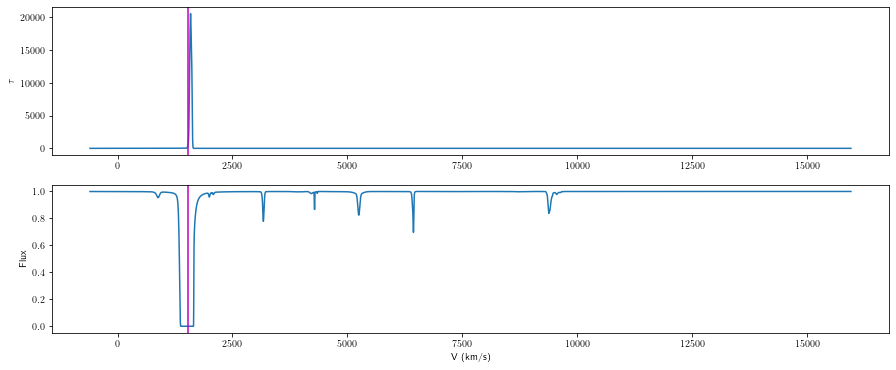

In [23]:
velocity = sf['velocity'][:]
wave = sf[f'{line}_wavelength'][:]
flux = sf[f'{line}_flux'][:]
noise = sf[f'{line}_noise'][:]
tau = sf[f'{line}_tau'][:]

fig, ax = plt.subplots(2, 1, figsize=(15, 6))
ax[0].plot(velocity, tau)
ax[0].set_ylabel(r'$\tau$')
ax[0].axvline(vgal, c='m')
ax[1].plot(velocity, flux)
ax[1].set_ylabel('Flux')
ax[1].set_xlabel('V (km/s)')
ax[1].axvline(vgal, c='m')

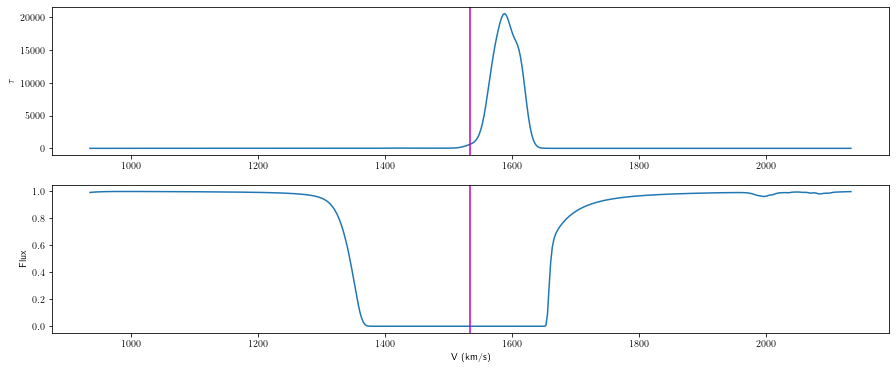

In [24]:
vel_mask = (velocity > vgal - vel_range) & (velocity < vgal + vel_range) 

fig, ax = plt.subplots(2, 1, figsize=(15, 6))
ax[0].plot(velocity[vel_mask], tau[vel_mask])
ax[0].set_ylabel(r'$\tau$')
ax[0].axvline(vgal, c='m')
ax[1].plot(velocity[vel_mask], flux[vel_mask])
ax[1].set_ylabel('Flux')
ax[1].set_xlabel('V (km/s)')
ax[1].axvline(vgal, c='m')

In [27]:
line_list = pg.analysis.fit_profiles(line, wave[vel_mask], flux[vel_mask]+noise[vel_mask], noise[vel_mask], chisq_lim=2.0, max_lines=7, logN_bounds=[12,17], b_bounds=[3,100], mode='Voigt')

Found 4 detection regions
Region 0: 1 lines gives chisq=0.72037 (2) after 22 iters
region 0 (1220.18-1220.3): chisq= 0.72037 with 1 lines
Region 1: 1 lines gives chisq=4.38374 (2) after 29 iters
Region 1: 2 lines gives chisq=1.98452 (2) after 72 iters
region 1 (1220.27-1222): chisq= 1.98452 with 2 lines
Region 2: 1 lines gives chisq=0.855983 (2) after 53 iters
region 2 (1221.95-1222.1): chisq= 0.855983 with 1 lines
Region 3: 1 lines gives chisq=0.556778 (2) after 31 iters
region 3 (1222.07-1222.16): chisq= 0.556778 with 1 lines


In [28]:
line_list

{'region': array([0., 1., 1., 2., 3.]),
 'l': array([1220.24033121, 1221.11263776, 1221.88631343, 1221.94769816,
        1222.13043389]),
 'dl': array([0.01720556, 0.0107765 , 0.04531718, 0.07556535, 0.01570264]),
 'b': array([13.47962822, 63.08522068, 22.81959679, 32.87405044,  9.69638244]),
 'db': array([10.90395734,  6.16062636, 36.17685355,  0.08528508,  7.75870658]),
 'N': array([12.00675716, 16.55472078, 12.63595974, 12.65373647, 12.01201138]),
 'dN': array([0.3566463 , 0.47588245, 0.61012249, 0.19209976, 0.27853216]),
 'EW': array([0.00459278, 1.31987114, 0.02086476, 0.01078008, 0.00365214])}

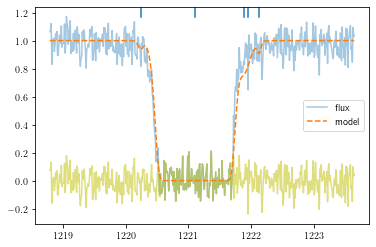

In [30]:
fig, ax = plt.subplots(1, 1)
model_flux, N, dN, b, db, l, dl, EW = pg.analysis.plot_fit(ax, wave[vel_mask], flux[vel_mask]+noise[vel_mask], noise[vel_mask], line_list, line)